In [ ]:
!pip install sentencepiece transformers[torch] bertviz datasets accelerate >=0.21.0

In [ ]:
!sudo pip install git+https://github.com/SalvatoreRa/ecco

# Attention and self-attention

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.W1 = nn.Linear(hidden_size, hidden_size)
        self.W2 = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)

    def forward(self, hidden, encoder_outputs):
        hidden_with_time_axis = hidden.unsqueeze(1)  # Adds a time dimension
        score = self.V(torch.tanh(self.W1(encoder_outputs) + self.W2(hidden_with_time_axis)))
        attention_weights = F.softmax(score, dim=0)  # Softmax over the sequence length dimension
        context_vector = torch.sum(attention_weights * encoder_outputs, dim=0)  # Sum weighted encoder outputs
        return context_vector, attention_weights

# Define dimensions
hidden_size = 128
seq_length = 10
batch_size = 1

# Initialize attention, generate random encoder output
attention = BahdanauAttention(hidden_size)
encoder_outputs = torch.randn(seq_length, batch_size, hidden_size)
hidden = torch.randn(batch_size, hidden_size)

# Compute context vector and attention weights
context_vector, attention_weights = attention(hidden, encoder_outputs)

# Display the results
print("Context Vector:", context_vector)
print("Attention Weights:", attention_weights.squeeze())

Context Vector: tensor([[ 0.1369, -0.1566,  0.0525, -0.1488, -0.2818,  0.1558, -0.5859,  0.0290,
         -0.4866,  0.1693,  0.0815,  0.1000, -0.1247, -0.4349, -0.3430,  0.0070,
          0.3561, -0.3239,  0.2367,  0.1508, -0.3977, -0.0466, -0.8670,  0.0590,
          0.6361, -0.2698,  0.0831, -0.2775,  0.2235, -0.3251, -0.6608, -0.3444,
         -1.0255,  0.0770, -0.2030, -0.0977, -0.2567,  0.0207,  0.2247,  0.3723,
          0.2516, -0.7230,  0.1308,  0.1134, -0.2262,  0.2657,  0.0619, -0.5592,
         -0.3423,  0.1750,  0.3111, -0.0686, -0.2000, -0.1724,  0.3506, -0.3414,
          0.1629,  0.3934, -0.2945, -0.2811, -0.0264,  0.3766,  0.2170, -0.1553,
          0.0894,  0.1024,  0.2324,  0.3733, -0.1403, -0.0844, -0.5460, -0.0601,
         -0.0748,  0.4834,  0.1473, -0.3060,  0.0210, -0.3800, -0.3688, -0.2223,
         -0.4547,  0.2063,  0.2800,  0.0154, -0.3355,  0.3440, -0.3079, -0.3250,
          0.4074,  0.0311,  0.2628, -0.5360,  0.4395,  0.1952, -0.2910,  0.4200,
          0.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Dimensions and sample data
embed_size = 64
seq_length = 10

queries_size, key_size, value_size = 32, 32, 64

class SelfAttention(nn.Module):
    def __init__(self, embed_size, queries_size, key_size, value_size):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.queries = torch.nn.Parameter(torch.rand(queries_size, embed_size))
        self.keys = torch.nn.Parameter(torch.rand(key_size, embed_size))
        self.values = torch.nn.Parameter(torch.rand(value_size, embed_size))

    def forward(self, x):
        Q = self.queries.matmul(x.T).T  # Query matrix
        K = self.keys.matmul(x.T).T     # Key matrix
        V = self.values.matmul(x.T)   # Value matrix

        # scaled dot product
        attention_scores = torch.matmul(Q, K.T) / (self.embed_size ** 0.5)

        attention_probs = F.softmax(attention_scores, dim=-1)
        print(attention_probs.shape), print(V.shape)
        attended_values = torch.matmul(attention_probs, V.T)
        return attended_values, attention_probs

# Dimensions and sample data
embed_size = 64
seq_length = 10
batch_size = 1

x = torch.randn(seq_length, embed_size)


attention = SelfAttention(embed_size, queries_size, key_size, value_size)
attended_values, attention_probs = attention(x)

print("Attended Values shape:", attended_values.shape)
print("Attention Probabilities shape:", attention_probs.shape)


torch.Size([10, 10])
torch.Size([64, 10])
Attended Values shape: torch.Size([10, 64])
Attention Probabilities shape: torch.Size([10, 10])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_size = embed_size
        self.num_heads = num_heads
        self.head_dim = embed_size // num_heads

        assert self.head_dim * num_heads == embed_size, "Embed size must be divisible by number of heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, queries):
        N = queries.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]

        # Split the embedding into self.num_heads different pieces
        values = values.reshape(N, value_len, self.num_heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.num_heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.num_heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        QK_product = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])


        attention = torch.softmax(QK_product / (self.embed_size ** (1 / 2)), dim=3)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.num_heads * self.head_dim)
        out = self.fc_out(out)
        return out

# Example usage
embed_size = 128  # Embedding size
num_heads = 8    # Number of heads in Multi-Head Attention
seq_length = 10  # Length of the sequence
batch_size = 1   # Batch size


model = MultiHeadSelfAttention(embed_size, num_heads)

x = torch.randn(batch_size, seq_length, embed_size)

out = model(x, x, x)
print("Output Shape:", out.shape)


Output Shape: torch.Size([1, 10, 128])


# The transformer

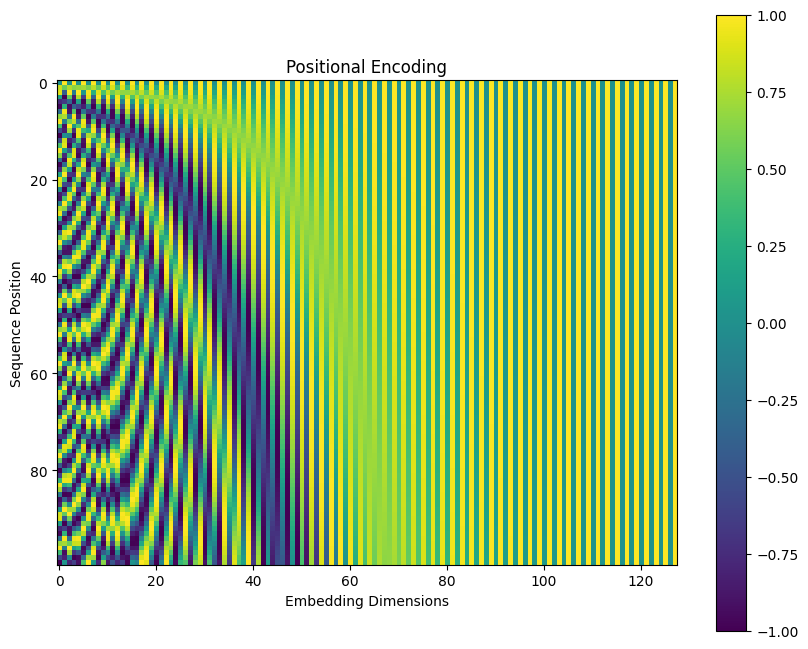

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def positional_encoding(seq_length, d_model, device='cpu'):
    """
    Generates a matrix of positional encodings.
    Returns:
    torch.Tensor: A tensor of shape (seq_length, d_model) containing the positional encodings.
    """
    position = torch.arange(seq_length).unsqueeze(1).float().to(device)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model)).to(device)

    pe = torch.zeros(seq_length, d_model).to(device)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    return pe

# Parameters
seq_length = 100  # Sequence length
d_model = 128     # Embedding dimension

pos_encoding = positional_encoding(seq_length, d_model)

plt.figure(figsize=(10, 8))
plt.imshow(pos_encoding.numpy(), cmap='viridis')
plt.colorbar()
plt.title("Positional Encoding")
plt.xlabel("Embedding Dimensions")
plt.ylabel("Sequence Position")
plt.savefig('positional_encoding.jpg', format='jpeg')
plt.show()


In [ ]:
from transformers import BertTokenizer
from IPython.display import HTML
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def bert_tokenize_and_color(text, tokenizer ):
    text = ' '.join(text)
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    colored_text = ""
    colors = ['#ff9999', '#99ff99', '#9999ff', '#ffff99', '#99ffff', '#ff99ff', '#cccccc',
              '#ff6666', '#66ff66', '#6666ff', '#ffff66', '#66ffff', '#ff66ff', '#ccccff',
              '#996699', '#669999', '#999966', '#669966', '#966696', '#696669']

    for token in tokens:
        color = colors[hash(token) % len(colors)]
        token_html = f'<span style="background-color:{color}">{token}</span>'
        colored_text += token_html + ' '

    return HTML(colored_text)

# Example usage
text = ['To be or not to be, that is the question.',
'Whether tis nobler in the mind to suffer',
'The slings and arrows of outrageous fortune',
'Or to take arms against a sea of troubles,',
'And by opposing, end them. To die, to sleep',
'No more, and by a sleep to say we end,',
'The heartache and the thousand natural shocks',
'That flesh is heir to, tis a consummation',
'Devoutly to be wished.']
bert_tokenize_and_color(text, tokenizer)


# Visualize internal mechanism

In [ ]:
from bertviz import head_view, model_view
from transformers import BertTokenizer, BertModel

model_version = 'bert-base-uncased'
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version)
sentence_a = "To be or not to be"
sentence_b = " To eat or not to eat the snack"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
head_view(attention, tokens, sentence_b_start)

<IPython.core.display.Javascript object>

In [ ]:
model_view(attention, tokens, sentence_b_start)

<IPython.core.display.Javascript object>

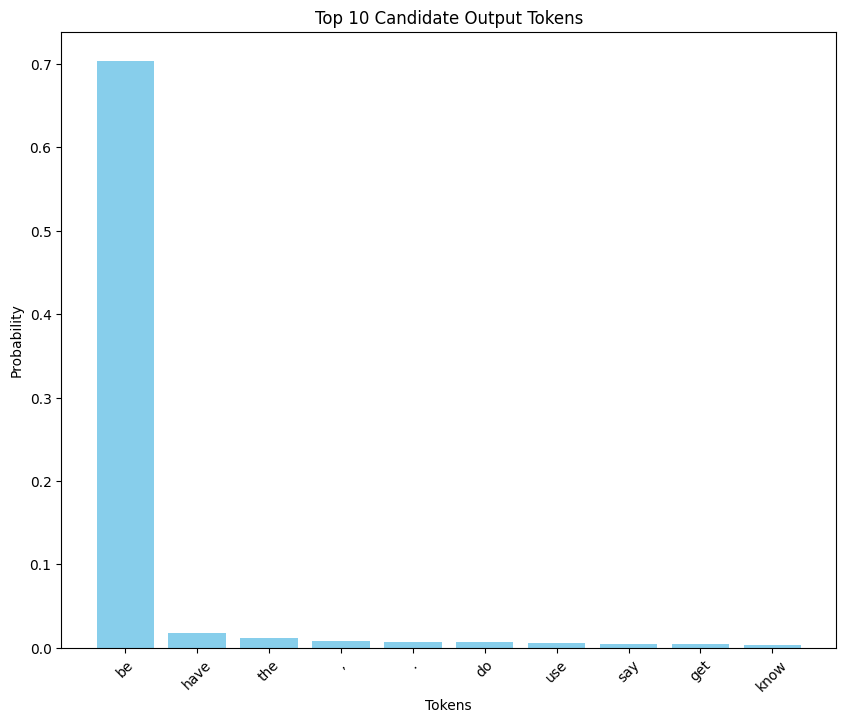

In [ ]:
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Tokenize the input text and generate output
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
inputs = tokenizer("To be or not to", return_tensors="pt")
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

# Get logits from the last layer
# Apply softmax to convert logits into probabilities
logits = outputs.logits
last_token_logits = logits[0, -1, :]
probabilities = torch.softmax(last_token_logits, dim=-1)

# Get the top 10 tokens and their probabilities
top_probabilities, top_indices = torch.topk(probabilities, 10)

top_tokens = tokenizer.convert_ids_to_tokens(top_indices)
top_tokens = [i.replace('Ġ', '') for i in top_tokens]

plt.figure(figsize=(10, 5))
plt.bar(top_tokens, top_probabilities.numpy(), color='skyblue')
plt.xlabel('Tokens')
plt.ylabel('Probability')
plt.title('Top 10 Candidate Output Tokens')
plt.xticks(rotation=45)
plt.savefig('Top 10 Candidate.jpg', bbox_inches='tight', format='jpeg')
plt.show()


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


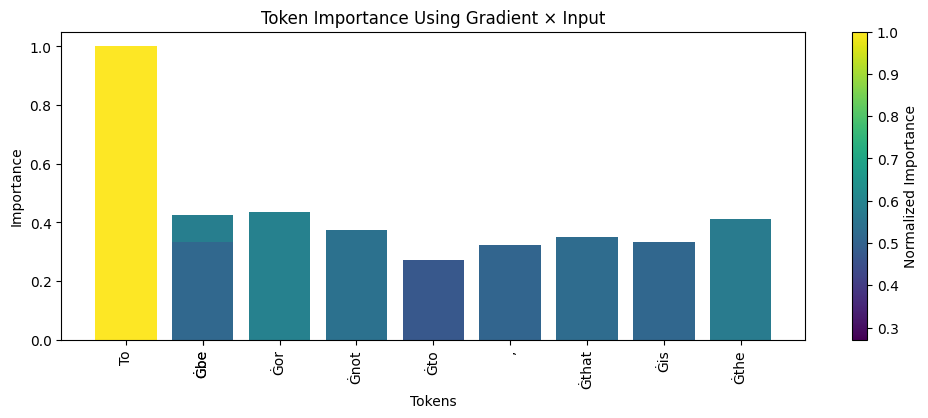

In [ ]:
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch


model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
inputs = tokenizer("To be or not to be, that is the", return_tensors="pt")
input_ids = inputs["input_ids"]

# Get embeddings and clone to make them a leaf in the graph
embeddings = model.transformer.wte(input_ids)
embeddings = embeddings.clone().detach()
embeddings.requires_grad = True

# Perform forward pass using embeddings
model.eval()
outputs = model(inputs_embeds=embeddings)
last_token_logits = outputs.logits[0, -1, :]


target_id = tokenizer.convert_tokens_to_ids('question')
target_logit = last_token_logits[target_id]

# Gradient × Input calculation
target_logit.backward()
grad_input = embeddings.grad * embeddings

# Sum of absolute gradient input values across embedding dimensions
importance_scores = grad_input.abs().sum(dim=-1).squeeze()

# Normalize scores for better visualization
importance_scores /= importance_scores.max()
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
tokens = [i.replace('Ġ', '') for i in tokens]

fig, ax = plt.subplots(figsize=(12, 4))
colors = plt.cm.viridis(importance_scores.detach().numpy())
bars = ax.bar(tokens, importance_scores.detach().numpy(), color=colors)
ax.set_xlabel('Tokens')
ax.set_ylabel('Importance')
ax.set_title('Token Importance Using Gradient × Input')
ax.set_xticks(tokens)
ax.set_xticklabels(tokens, rotation=90)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=importance_scores.min(), vmax=importance_scores.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Normalized Importance')
plt.savefig('Top tokens.jpg', bbox_inches='tight', format='jpeg')
plt.show()


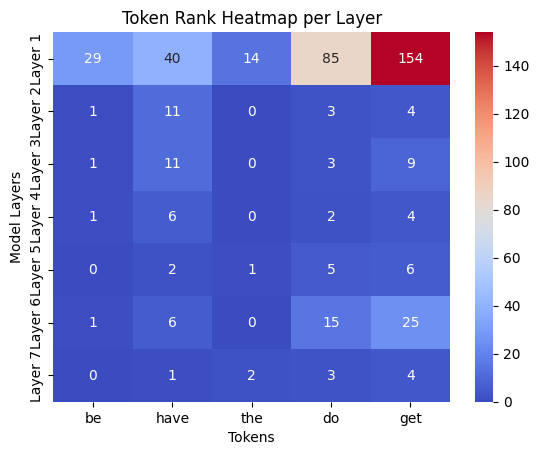

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')
model = GPT2LMHeadModel.from_pretrained('distilgpt2', output_hidden_states=True)
input_ids = tokenizer.encode('to be or not to', return_tensors='pt')

# Predict logits for the next token
with torch.no_grad():
    outputs = model(input_ids)
    last_hidden_state = outputs.hidden_states[-1][0, -1, :]
    logits = model.lm_head(last_hidden_state)

# Select top 5 tokens
_, top_indices = torch.topk(logits, 5)
top_tokens = tokenizer.convert_ids_to_tokens(top_indices)

# Function to get ranks for the selected top tokens across each layer
def get_ranks(hidden_states, top_indices):
    ranks = np.zeros((len(hidden_states), len(top_indices)), dtype=int)
    for i, state in enumerate(hidden_states):
        logits = model.lm_head(state[0, -1, :])
        sorted_indices = torch.argsort(logits, descending=True)
        for j, token_idx in enumerate(top_indices):
            rank = (sorted_indices == token_idx).nonzero(as_tuple=True)[0].item()
            ranks[i, j] = rank
    return ranks

# Compute ranks
ranks_matrix = get_ranks(outputs.hidden_states, top_indices)
top_tokens = [i.replace('Ġ', '') for i in top_tokens]

sns.heatmap(ranks_matrix, annot=True, cmap='coolwarm', fmt="d", xticklabels=top_tokens, yticklabels=[f'Layer {i+1}' for i in range(len(outputs.hidden_states))])
plt.title('Token Rank Heatmap per Layer')
plt.xlabel('Tokens')
plt.ylabel('Model Layers')
plt.show()


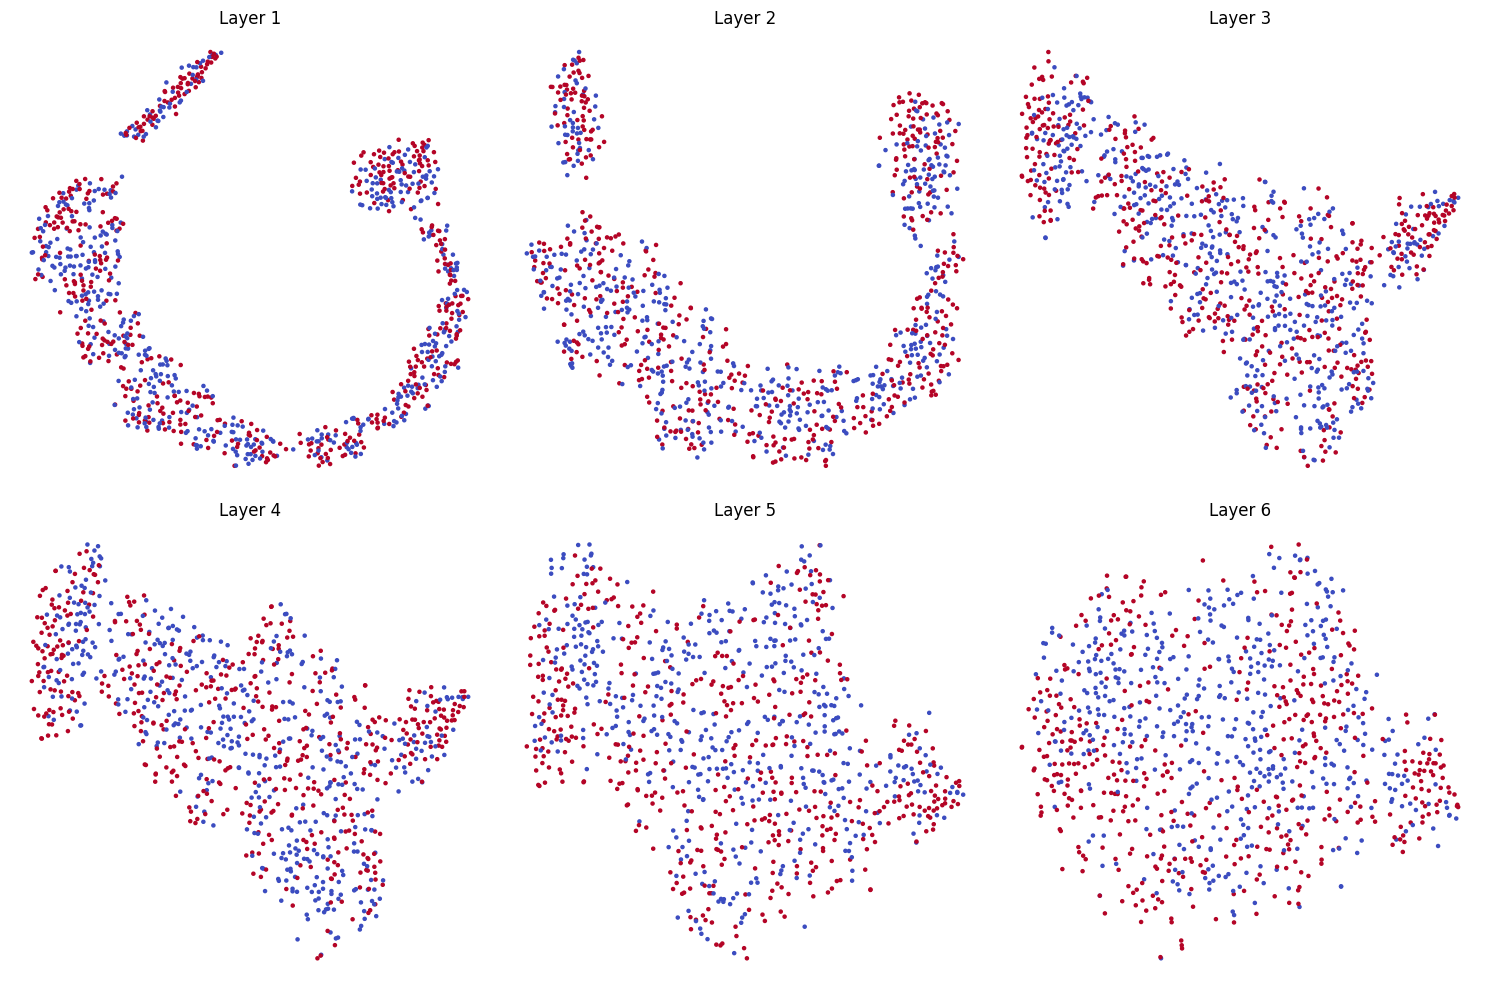

In [ ]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load the DataFrame
try:
    df = pd.read_csv("IMDB Dataset.csv")
except:
    !wget https://github.com/SalvatoreRa/tutorial/blob/main/datasets/IMDB.zip?raw=true
    !unzip IMDB.zip?raw=true
    df = pd.read_csv("IMDB Dataset.csv")

df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
df = df.iloc[:1000]

model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Function to get hidden states
def get_hidden_states(text):
    tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**tokens)
    hidden_states = outputs.hidden_states
    return [hidden_state.squeeze(0).mean(dim=0) for hidden_state in hidden_states]


df['hidden_states'] = df['review'].apply(get_hidden_states)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i in range(6):  # Assuming DistilGPT2 has 6 layers
    layer_hidden_states = torch.stack(df['hidden_states'].map(lambda x: x[i]).tolist())
    reducer = TSNE(n_components=2, random_state=42)
    tsne_result = reducer.fit_transform(layer_hidden_states.detach().numpy())
    axs[i].scatter(tsne_result[:, 0], tsne_result[:, 1], c=df['sentiment'], cmap='coolwarm', s=5)
    axs[i].set_title(f'Layer {i+1}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import ecco
lm = ecco.from_pretrained('distilgpt2', activations=True)
text = " To be or not to"

# Generate one token
output_1 = lm.generate(text, generate=1, do_sample=False)

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<IPython.core.display.Javascript object>

In [ ]:
text = " 1,2,3"

# Generate one token
output_2 = lm.generate(text, generate=20, do_sample=False)

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Factorize activations in all the layers
nmf_1 = output_2.run_nmf(n_components=3)
nmf_1.explore()

<IPython.core.display.Javascript object>

In [ ]:
text = '''  To be, or not to be: that is the question: Whether 'tis nobler in the mind to suffer The slings and arrows of outrageous fortune, Or to take arms against a sea of troubles, And by opposing end them? To die: to sleep; No more; and by a sleep to say we end The heart-ache and the thousand natural shocks That flesh is heir to, 'tis a consummation Devoutly to be wish'd. To die, to sleep; To sleep: perchance to dream: ay, there's the rub; For in that sleep of death what dreams may come When we have shuffled off this mortal coil, Must give us pause: there's the respect That makes calamity of so long life; For who would bear the whips and scorns of time, The oppressor's wrong, the proud man's contumely, The pangs of despised love, the law's delay, The insolence of office and the spurns That patient merit of the unworthy takes, When he himself might his quietus make With a bare bodkin? who would fardels bear, To grunt and sweat under a weary life, But that the dread of something after death, The undiscover'd country from whose bourn No traveller returns, puzzles the will And makes us rather bear those ills we have Than fly to others that we know not of? Thus conscience does make cowards of us all; And thus the native hue of resolution Is sicklied o'er with the pale cast of thought, And enterprises of great pith and moment With this regard their currents turn awry, And lose the name of action. - Soft you now! The fair Ophelia! Nymph, in thy orisons Be all my sins remember'd.
'''
output = lm.generate(text, generate=1, do_sample=True)

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


<IPython.core.display.Javascript object>

In [ ]:
# Factorize activations in all the layers
nmf_1 = output.run_nmf(n_components=10, from_layer=0, to_layer=1)
nmf_1.explore()

<IPython.core.display.Javascript object>

# Application of the transformer

## Fine tuning

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
from datasets import Dataset

try:
    df=pd.read_csv("IMDB Dataset.csv")
except:
    !wget https://github.com/SalvatoreRa/tutorial/blob/main/datasets/IMDB.zip?raw=true
    !unzip IMDB.zip?raw=true
    df=pd.read_csv("IMDB Dataset.csv")
df = df.iloc[:2000,:]

# Convert labels to numerical format
label_dict = {'positive': 1, 'negative': 0}
df['label'] = df['sentiment'].map(label_dict)

# Split the data and tokenize them
train_df, val_df = train_test_split(df, test_size=0.1)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['review'], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
from transformers import DistilBertForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch"      # evaluate each epoch
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

results = trainer.evaluate()
print(results)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 0.605488657951355, 'eval_runtime': 0.6819, 'eval_samples_per_second': 293.3, 'eval_steps_per_second': 19.064, 'epoch': 3.0}


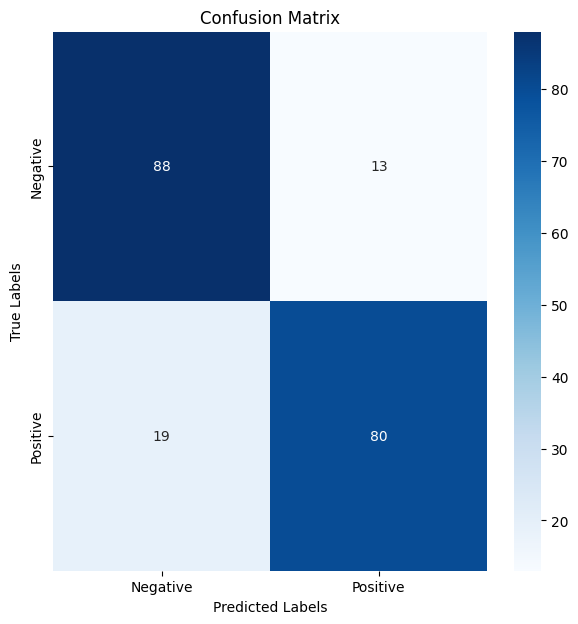

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Generate predictions
predictions = trainer.predict(val_dataset)
# Extract logits
logits = predictions.predictions
# Convert logits to class labels
predicted_labels = np.argmax(logits, axis=-1)
actual_labels = val_dataset['label']

# Compute the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

plt.figure(figsize=(7,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('fine tuning confusion matrix.jpg', bbox_inches='tight', format='jpeg')
plt.show()


## Knowledge distillation

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertForSequenceClassification
from datasets import Dataset
from transformers import Trainer, TrainingArguments

try:
    df=pd.read_csv("IMDB Dataset.csv")
except:
    !wget https://github.com/SalvatoreRa/tutorial/blob/main/datasets/IMDB.zip?raw=true
    !unzip IMDB.zip?raw=true
df = df.iloc[:2000,:]

label_dict = {'positive': 1, 'negative': 0}
df['label'] = df['sentiment'].map(label_dict)

# Split the data
train_df, val_df = train_test_split(df, test_size=0.1)


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['review'], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [ ]:
teacher_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

training_args = TrainingArguments(
    output_dir='./results_teacher',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model=teacher_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TrainOutput(global_step=675, training_loss=0.2786323928833008, metrics={'train_runtime': 144.7088, 'train_samples_per_second': 37.316, 'train_steps_per_second': 4.665, 'total_flos': 355199924736000.0, 'train_loss': 0.2786323928833008, 'epoch': 3.0})

In [ ]:
student_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
from torch.utils.data import DataLoader
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator(return_tensors="pt")
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=16, collate_fn=data_collator)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.nn import KLDivLoss, functional as F
from tqdm.auto import tqdm
from transformers import AdamW
import torch

# Prepare model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model.to(device)
teacher_model.to(device)
optimizer = AdamW(student_model.parameters(), lr=5e-5)


def distillation_loss(outputs_student, outputs_teacher, temperature=2.0):
    """
    Calculate the knowledge distillation loss between the teacher and student outputs
    using KL Divergence. This function assumes that the outputs are logits.
    """
    log_prob_student = F.log_softmax(outputs_student / temperature, dim=-1)
    prob_teacher = F.softmax(outputs_teacher / temperature, dim=-1)
    # Calculate KL Divergence Loss
    loss = KLDivLoss(reduction='batchmean')(log_prob_student, prob_teacher)
    return loss


def train_epoch(model, dataloader, optimizer, device, teacher_model, temperature=2.0):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}

        with torch.no_grad():
            outputs_teacher = teacher_model(**inputs).logits

        outputs_student = model(**inputs).logits

        loss = distillation_loss(outputs_student, outputs_teacher, temperature)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, device, teacher_model, temperature=2.0):
    model.eval()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Evaluating"):
        inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}

        with torch.no_grad():
            outputs_teacher = teacher_model(**inputs).logits
            outputs_student = model(**inputs).logits
            loss = distillation_loss(outputs_student, outputs_teacher, temperature)
            total_loss += loss.item()

    return total_loss / len(dataloader)


epochs = 3
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss = train_epoch(student_model, train_dataloader, optimizer, device, teacher_model)
    print(f"Training Loss: {train_loss}")

    val_loss = validate(student_model, val_dataloader, device, teacher_model)
    print(f"Validation Loss: {val_loss}")

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Training Loss: 0.36310692114962473


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss: 0.2496768287741221
Epoch 2/3


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Training Loss: 0.17176356011691193


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss: 0.15958464661469826
Epoch 3/3


Training:   0%|          | 0/225 [00:00<?, ?it/s]

Training Loss: 0.07090722223536836


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss: 0.23586274912724128


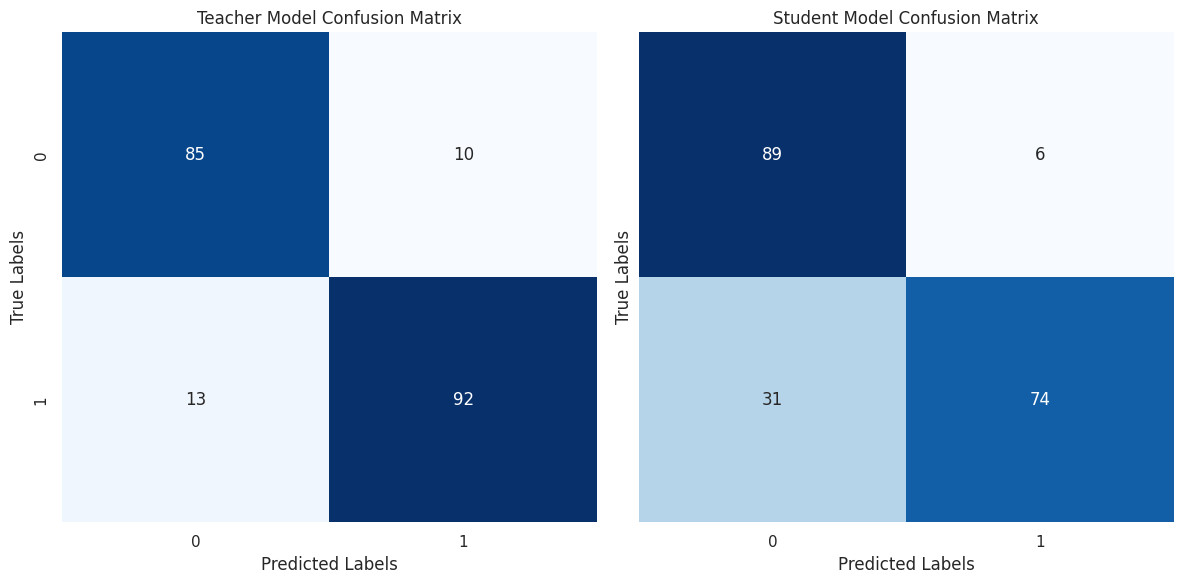

In [ ]:
import torch

def get_predictions(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(batch['labels'].cpu().numpy())

    return all_true_labels, all_predictions

teacher_labels, teacher_preds = get_predictions(teacher_model, val_dataloader, device)
student_labels, student_preds = get_predictions(student_model, val_dataloader, device)

from sklearn.metrics import confusion_matrix

teacher_cm = confusion_matrix(teacher_labels, teacher_preds)
student_cm = confusion_matrix(student_labels, student_preds)

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
def plot_confusion_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(title)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
plot_confusion_matrix(teacher_cm, 'Teacher Model Confusion Matrix', ax1)
plot_confusion_matrix(student_cm, 'Student Model Confusion Matrix', ax2)

plt.tight_layout()
plt.show()
